https://www.kaggle.com/c/dmia-production-ml-2021-1-passwords  
https://gitlab.com/production-ml/password_app  
https://gitlab.com/vaaliferov/passwords  
http://valiferov.pythonanywhere.com  
https://t.me/vaaliferov_passw_bot  

https://pypi.org/project/password-strength/  
https://wpengine.com/resources/passwords-unmasked-infographic/  
https://github.com/danielmiessler/SecLists/blob/master/Passwords/Common-Credentials/10-million-password-list-top-1000000.txt  
https://github.com/danielmiessler/SecLists/blob/master/Passwords/Common-Credentials/10-million-password-list-top-100000.txt  
https://www.kaggle.com/haimfeld87/simple-catboost  
https://seaborn.pydata.org/examples/many_pairwise_correlations.html  
https://github.com/gkbrk/passwordstrength  
https://github.com/first20hours/google-10000-english  
https://github.com/dominictarr/random-name/blob/master/names.txt  
https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists#English  
https://github.com/derekchuank/high-frequency-vocabulary/blob/master/30k.txt 
https://pypi.org/project/pyspellchecker/  
https://stackoverflow.com/questions/13928155/spell-checker-for-python  

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from password_strength import PasswordStats

In [8]:
class TopPasswords:

    def __init__(self, path):
        i = 0
        f = open(path)
        self.d = dict()
        for l in f:
            i = i + 1
            self.d[l[:-1]] = i
        f.close()

    def get_idx(self, passw):
        return self.d[passw] if passw in self.d else 0

In [9]:
class TopNames:

    def __init__(self, path):
        i = 0
        f = open(path)
        self.d = dict()
        for l in f:
            i = i + 1
            n = l[:-1].lower()
            self.d[n] = i
        f.close()

    def get_idx(self, name):
        return self.d[name.lower()] if name.lower() in self.d else 0

In [15]:
class TopWords:

    def __init__(self, path):
        i = 0
        f = open(path)
        self.d = dict()
        for l in f:
            i = i + 1
            n = l[:-2].lower()
            self.d[n] = i
        f.close()

    def get_idx(self, word):
        return self.d[word.lower()] if word.lower() in self.d else 0

In [16]:
top_passw = TopPasswords('../data/passwords_1m.txt')
top_names = TopNames('../data/names_22k.txt')
top_words = TopWords('../data/words_30k.txt')

In [18]:
def rmsle1(y, h): 
    return np.sqrt(mean_squared_log_error(y, h))

def rmsle2(y, h): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

def extract_features(data):
    X, p = pd.DataFrame(), data['Password']
    X['length'] = p.str.len()
    X['top_idx'] = p.transform(top_passw.get_idx)
    X['no_top_idx'] = (X['top_idx'] == 0).astype(int)
    X['top_name_idx'] = p.transform(top_names.get_idx)
    X['no_top_name_idx'] = (X['top_name_idx'] == 0).astype(int)
    X['top_word_idx'] = p.transform(top_words.get_idx)
    X['no_top_word_idx'] = (X['top_word_idx'] == 0).astype(int)
    X['strength'] = p.transform(lambda x: PasswordStats(x).strength())
    X['letters'] = p.transform(lambda x: PasswordStats(x).letters)
    X['entropy_bits'] = p.transform(lambda x: PasswordStats(x).entropy_bits)
    X['entropy_density'] = p.transform(lambda x: PasswordStats(x).entropy_density if len(x) > 1 else 0)
    X['letters_lowercase'] = p.transform(lambda x: PasswordStats(x).letters_lowercase)
    X['letters_uppercase'] = p.transform(lambda x: PasswordStats(x).letters_uppercase)
    X['numbers'] = p.transform(lambda x: PasswordStats(x).numbers)
    X['repeated_patterns_length'] = p.transform(lambda x: PasswordStats(x).repeated_patterns_length)
    X['sequences_length'] = p.transform(lambda x: PasswordStats(x).sequences_length)
    X['special_characters'] = p.transform(lambda x: PasswordStats(x).special_characters)
    return X

In [19]:
%%time
train_data = pd.read_csv('../data/train.csv')
train_data = train_data.dropna()
X = extract_features(train_data)
y = train_data['Times']

CPU times: user 4min 25s, sys: 1.51 s, total: 4min 26s
Wall time: 4min 26s


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
%%time

model = CatBoostRegressor(
    depth=6, 
    num_trees=70, 
    loss_function='RMSE', 
    eval_metric='RMSE', 
    random_state=42, 
    verbose=200
)

model.fit(X_train, np.log1p(y_train))

Learning rate set to 0.5
0:	learn: 0.2133167	total: 405ms	remaining: 28s
69:	learn: 0.0161425	total: 21.6s	remaining: 0us
CPU times: user 1min 15s, sys: 3 s, total: 1min 18s
Wall time: 22.3 s


In [22]:
cols = X_train.columns.tolist()
imps = model.get_feature_importance()
sorted(zip(cols, imps), key=lambda x: x[1], reverse=True)

[('top_idx', 55.72998310176456),
 ('no_top_idx', 44.067295311338675),
 ('letters', 0.07336723444914343),
 ('top_word_idx', 0.052307893055048085),
 ('top_name_idx', 0.023617764039338345),
 ('strength', 0.010738484005729635),
 ('sequences_length', 0.008035513684296069),
 ('numbers', 0.007692905820853234),
 ('repeated_patterns_length', 0.007006471802049513),
 ('letters_lowercase', 0.006244070774227717),
 ('length', 0.004902951834286806),
 ('entropy_bits', 0.003642354264136056),
 ('entropy_density', 0.0035958339659444265),
 ('letters_uppercase', 0.0015701092016992839),
 ('no_top_name_idx', 0.0),
 ('no_top_word_idx', 0.0),
 ('special_characters', 0.0)]

In [23]:
y_pred = model.predict(X_train)
y_pred = np.exp(y_pred) - 1
y_pred[y_pred < 0] = 1
print(rmsle1(y_train, y_pred))
print(rmsle2(y_train, y_pred))

0.01614252174206232
0.01614252174206232


In [24]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred) - 1
y_pred[y_pred < 0] = 1
print(rmsle1(y_test, y_pred))
print(rmsle2(y_test, y_pred))

0.016962172654832547
0.016962172654832543


In [25]:
%%time
test_data = pd.read_csv('../data/test.csv')
test_data = test_data.fillna(' ')
X_submission = extract_features(test_data)
submission = pd.read_csv('../data/sample_submission.csv')
submission['Times'] = model.predict(X_submission)
submission['Times'] = np.exp(submission['Times']) - 1
submission.loc[submission['Times'] < 0, 'Times'] = 1
submission.to_csv('../data/my_submission.csv', index=False)

CPU times: user 1min 7s, sys: 308 ms, total: 1min 7s
Wall time: 1min 7s


In [23]:
model.save_model('../model/pass.cbm')

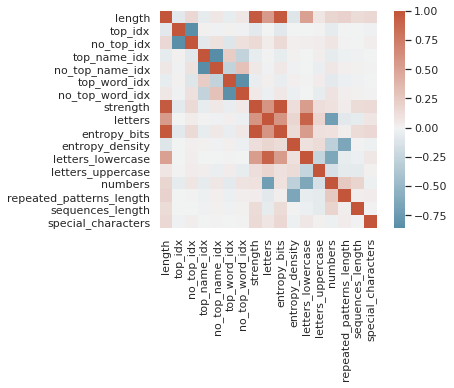

In [27]:
corr = X.corr()
sns.set_theme(style="white")
f, ax = plt.subplots(figsize=(6, 4))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0, square=True);